Welcome to JupyROOT 6.28/04
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001381_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001381_001.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001382_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001382_001.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001383_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001383_001.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001384_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001384_001.root
*** WARNING: CRV_spill: getTempCMB: Spill # 7 has no actual event
!!! spill 0, 0007 DQM = 0x6
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001385_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001385_001.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001386_000.root
Reading file: rec.mu

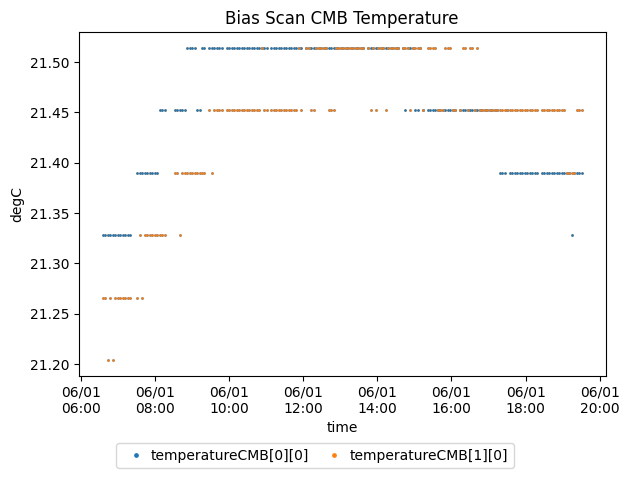

In [1]:
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
# from ROOT import TCanvas, TH1F, TH2F, TF1, TMath, TGraph, TFile, TSpectrum, TPaveText, TMultiGraph, TGraphErrors, TLine
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvled-002'][0])

fileList = filepath.getfilelist(["trim_scan_led_like"])[0]

trimScanRun = filepath.datatag["trim_scan_led_like"]["run#"][:9]
trimScanFileList = list(filter(lambda x: filepath.filenameparser(x, 'run') in trimScanRun, fileList))
DeltaTrim = [filepath.datatag["trim_scan_led_like"]["trim"][filepath.datatag["trim_scan_led_like"]["run#"].index(filepath.filenameparser(filename, 'run'))] for filename in trimScanFileList]
DeltaTrimDivideMinus10 = [itrim/(-10.) for itrim in DeltaTrim]

bulkScanRun = [filepath.datatag["trim_scan_led_like"]["run#"][0]]+filepath.datatag["trim_scan_led_like"]["run#"][9:]
bulkScanFileList = list(filter(lambda x: filepath.filenameparser(x, 'run') in bulkScanRun, fileList))
DeltaBulk = [filepath.datatag["trim_scan_led_like"]["bulk"][filepath.datatag["trim_scan_led_like"]["run#"].index(filepath.filenameparser(filename, 'run'))] for filename in bulkScanFileList]

nSmooth = 1 
tdict = {'*':[["temperatureCMB[0][0]","temperatureCMB[1][0]"]]}
tfig = utils.plot_dqm(fileList, tdict, '==0x0', False, nSmooth, True, "Bias Scan CMB Temperature;time;degC") 

Temperature difference of 0.3 $^\circ C$. With a temperature constant of about -8 ADC$\times$ns/PE, and calibration constants around 300 ADC$\times$ns/PE, the influence from the temperature is < 1\%. With the purpose of scan analysis, this systematic error is negligible. So here will use the raw SPE values.

In [2]:
nFEB = geometry_constants.setup_dict['crvled-002'][0]['nFEB']
trimSPERaw = [[[] for iCh in range(geometry_constants.nChannelPerFEB)] for iFEB in range(nFEB)]
bulkSPERaw = [[[] for iCh in range(geometry_constants.nChannelPerFEB)] for iFEB in range(nFEB)]

for filename in trimScanFileList:
    calibRaw = utils.calibExtract_root(filename)[1]
    for iFEB in range(nFEB):
        for iCh in range(geometry_constants.nChannelPerFEB):
            trimSPERaw[iFEB][iCh].append(calibRaw[iFEB][iCh])

for filename in bulkScanFileList:
    calibRaw = utils.calibExtract_root(filename)[1]
    for iFEB in range(nFEB):
        for iCh in range(geometry_constants.nChannelPerFEB):
            bulkSPERaw[iFEB][iCh].append(calibRaw[iFEB][iCh])

Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001381_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001381_001.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001382_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001382_001.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001383_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001383_001.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001384_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001384_001.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001385_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001385

In [3]:
fMG_scan = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
fGraph_trimSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
fGraph_bulkSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
func_trimSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
func_bulkSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]

slope_trim = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
slope_bulk = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
slope_diff = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]

vover_trim = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
vover_bulk = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
vover_diff = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]

c01 = ROOT.TCanvas("c01", "c01", 640*2, 480*64)
c01.Divide(2, 64, 0.001, 0.001)
for iFEB in range(nFEB):
    for iCh in range(geometry_constants.nChannelPerFEB):
        c01.cd(iFEB*geometry_constants.nChannelPerFEB+iCh+1)
        
        fMG_scan[iFEB][iCh] = ROOT.TMultiGraph("fMG_scan_%i_%i"%(iFEB, iCh), "Calibration Constant at Different Bias Settings; #Deltabulk, or -#Deltatrim/10 [ADC]; Calibration Constant [ADC#timesns/PE]")
                
        fGraph_trimSPE[iFEB][iCh] = ROOT.TGraph(len(DeltaTrimDivideMinus10), array('d', DeltaTrimDivideMinus10), array('d', trimSPERaw[iFEB][iCh]))
        fGraph_trimSPE[iFEB][iCh].SetName("scat_trimSPE_%i_%i"%(iFEB, iCh))
        fGraph_trimSPE[iFEB][iCh].SetTitle("Calibration Constant at Different Bias Settings; #Deltabulk, or -#Deltatrim/10 [ADC]; Calibration Constant [ADC#timesns/PE]")
        fGraph_trimSPE[iFEB][iCh].SetMarkerStyle(27)
        fGraph_trimSPE[iFEB][iCh].SetMarkerColor(2)
        fGraph_trimSPE[iFEB][iCh].SetLineColor(2)
        fGraph_trimSPE[iFEB][iCh].SetLineWidth(0)
        fGraph_trimSPE[iFEB][iCh].SetMarkerSize(2)
        fMG_scan[iFEB][iCh].Add(fGraph_trimSPE[iFEB][iCh])
        
        fGraph_bulkSPE[iFEB][iCh] = ROOT.TGraph(len(DeltaBulk), array('d', DeltaBulk), array('d', bulkSPERaw[iFEB][iCh]))
        fGraph_bulkSPE[iFEB][iCh].SetName("scat_bulkSPE_%i_%i"%(iFEB, iCh))
        fGraph_bulkSPE[iFEB][iCh].SetTitle("Calibration Constant at Different Bias Settings; #Deltabulk, or -#Deltatrim/10 [ADC]; Calibration Constant [ADC#timesns/PE]")
        fGraph_bulkSPE[iFEB][iCh].SetMarkerStyle(28)
        fGraph_bulkSPE[iFEB][iCh].SetMarkerColor(4)
        fGraph_bulkSPE[iFEB][iCh].SetLineColor(4)
        fGraph_bulkSPE[iFEB][iCh].SetLineWidth(0)
        fGraph_bulkSPE[iFEB][iCh].SetMarkerSize(2)
        fMG_scan[iFEB][iCh].Add(fGraph_bulkSPE[iFEB][iCh])
        
        fMG_scan[iFEB][iCh].GetXaxis().SetLimits(-60.,60.)
        # fMG_scan[iFEB][iCh].GetHistogram().SetMaximum(500.)
        # fMG_scan[iFEB][iCh].GetHistogram().SetMinimum(0.)
        fMG_scan[iFEB][iCh].DrawClone("AP")
        
        trim_x_temp = []
        trim_y_temp = []
        for i in range(len(DeltaTrimDivideMinus10)):
            if trimSPERaw[iFEB][iCh][i] != 0.:
                trim_x_temp.append(DeltaTrimDivideMinus10[i])
                trim_y_temp.append(trimSPERaw[iFEB][iCh][i])
        temp_trim_graph = ROOT.TGraph(len(trim_x_temp), array('d', trim_x_temp), array('d', trim_y_temp))
                                      
        bulk_x_temp = []
        bulk_y_temp = []
        for i in range(len(DeltaBulk)):
            if bulkSPERaw[iFEB][iCh][i] != 0.:
                bulk_x_temp.append(DeltaBulk[i])
                bulk_y_temp.append(bulkSPERaw[iFEB][iCh][i])
        temp_bulk_graph = ROOT.TGraph(len(bulk_x_temp), array('d', bulk_x_temp), array('d', bulk_y_temp))

        func_trimSPE[iFEB][iCh] = ROOT.TF1("func_trimSPE_%i_%i"%(iFEB, iCh), "[0]*x+[1]", -60., 60.)
        func_trimSPE[iFEB][iCh].SetParameter(0, 2.5)
        func_trimSPE[iFEB][iCh].SetParameter(1, 400.)
        func_trimSPE[iFEB][iCh].SetParName(0, "k")
        func_trimSPE[iFEB][iCh].SetParName(1, "b")
        func_trimSPE[iFEB][iCh].SetParLimits(0, 0.,100.)
        func_trimSPE[iFEB][iCh].SetParLimits(1, 0.,1000.)
        tfrp_trim = temp_trim_graph.Fit(func_trimSPE[iFEB][iCh], "QRSF")
        func_trimSPE[iFEB][iCh].SetLineColor(2)
        func_trimSPE[iFEB][iCh].SetLineWidth(1)
        # func_trimSPE[iFEB][iCh].SetLineStyle(4)
        func_trimSPE[iFEB][iCh].DrawClone("SAME")
        trim_k = func_trimSPE[iFEB][iCh].GetParameter(0)
        trim_k_err = func_trimSPE[iFEB][iCh].GetParError(0)
        trim_b = func_trimSPE[iFEB][iCh].GetParameter(1)
        trim_b_err = func_trimSPE[iFEB][iCh].GetParError(1)
        slope_trim[iFEB][iCh] = trim_k
        vover_trim[iFEB][iCh] = trim_b/trim_k*20./1000.
        
        func_bulkSPE[iFEB][iCh] = ROOT.TF1("func_bulkSPE_%i_%i"%(iFEB, iCh), "[0]*x+[1]", -60., 60.)
        func_bulkSPE[iFEB][iCh].SetParameter(0, 2.5)
        func_bulkSPE[iFEB][iCh].SetParameter(1, 400.)
        func_bulkSPE[iFEB][iCh].SetParName(0, "k")
        func_bulkSPE[iFEB][iCh].SetParName(1, "b")
        func_bulkSPE[iFEB][iCh].SetParLimits(0, 0.,100.)
        func_bulkSPE[iFEB][iCh].SetParLimits(1, 0.,1000.)
        tfrp_bulk = temp_bulk_graph.Fit(func_bulkSPE[iFEB][iCh], "QRSF")
        func_bulkSPE[iFEB][iCh].SetLineColor(4)
        func_bulkSPE[iFEB][iCh].SetLineWidth(1)
        # func_bulkSPE[iFEB][iCh].SetLineStyle(8)
        func_bulkSPE[iFEB][iCh].DrawClone("SAME")
        bulk_k = func_bulkSPE[iFEB][iCh].GetParameter(0)
        bulk_k_err = func_bulkSPE[iFEB][iCh].GetParError(0)
        bulk_b = func_bulkSPE[iFEB][iCh].GetParameter(1)
        bulk_b_err = func_bulkSPE[iFEB][iCh].GetParError(1)
        slope_bulk[iFEB][iCh] = bulk_k
        vover_bulk[iFEB][iCh] = bulk_b/bulk_k*20./1000.
        
        slope_diff[iFEB][iCh] = bulk_k - trim_k
        vover_diff[iFEB][iCh] = vover_bulk[iFEB][iCh] - vover_trim[iFEB][iCh]
        
        fLegend = ROOT.TLegend(0.4, 0.12, 0.9, 0.35)
        fLegend.SetHeader("FEB%i_Ch%02i"%(iFEB, iCh),"C")
        fLegend.AddEntry(fGraph_trimSPE[iFEB][iCh], "trim k = %.2f#pm%.2f, b = %.2f#pm%.2f"%(trim_k, trim_k_err, trim_b, trim_b_err))
        fLegend.AddEntry(fGraph_bulkSPE[iFEB][iCh], "bulk k = %.2f#pm%.2f, b = %.2f#pm%.2f"%(bulk_k, bulk_k_err, bulk_b, bulk_b_err))
        fLegend.DrawClone("SAME")
        
c01.Draw()

Text(0, 0.5, 'counts')

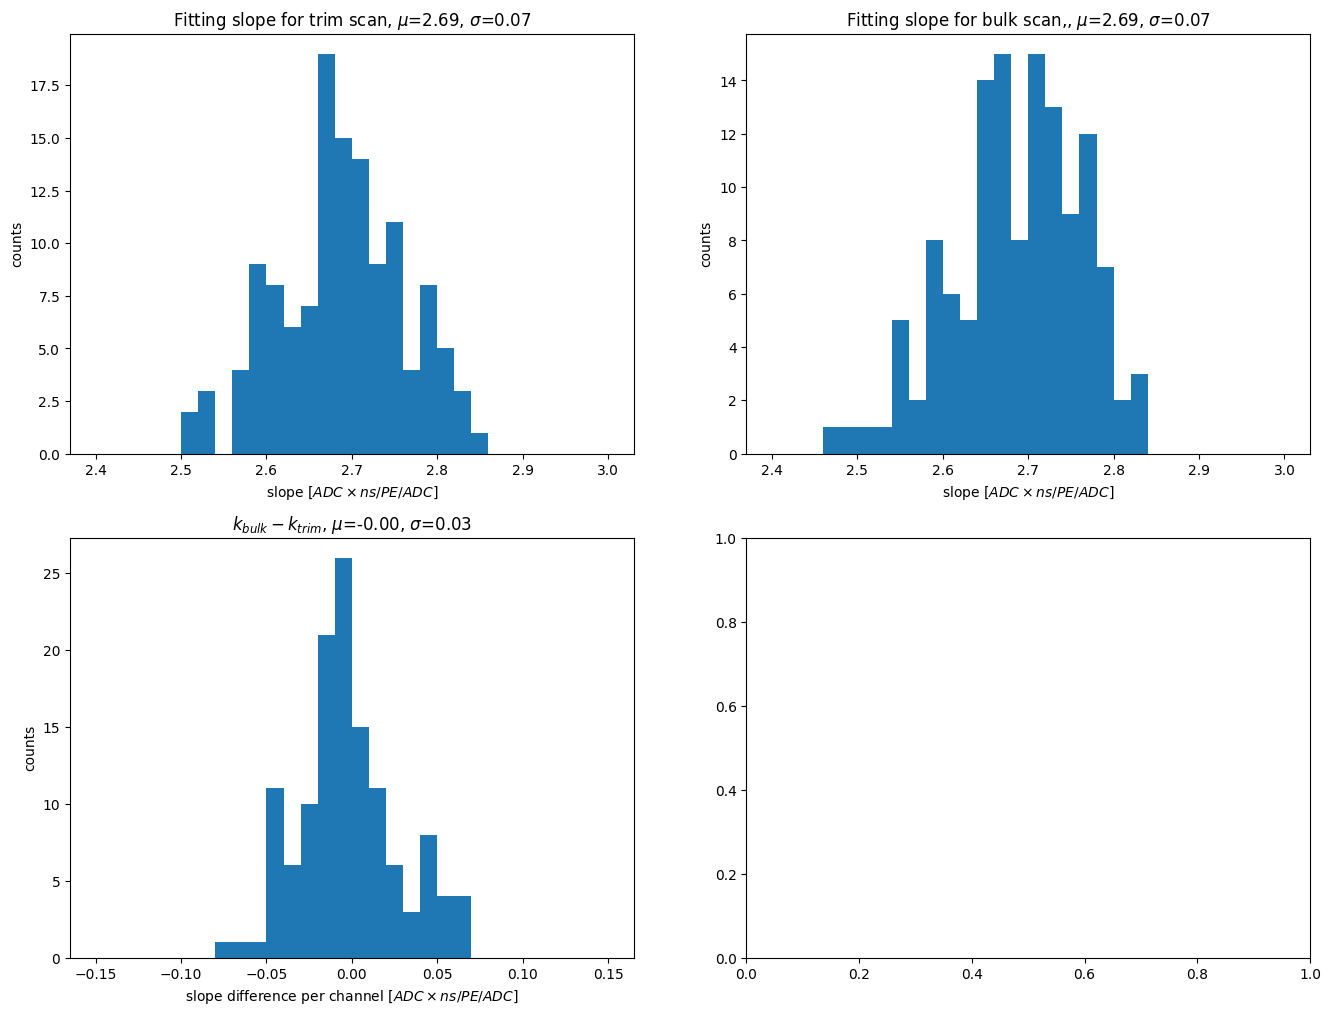

In [4]:
slope_trim = np.array(slope_trim).flatten()
slope_bulk = np.array(slope_bulk).flatten()
slope_diff = np.array(slope_diff).flatten()

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes[0,0].hist(slope_trim, [2.4+0.02*i for i in range(30+1)])
axes[0,0].set_title("Fitting slope for trim scan, "+r'$\mu$'+"=%.2f"%(np.mean(slope_trim))+r', $\sigma$'+"=%.2f"%(np.std(slope_trim)))
axes[0,0].set_xlabel("slope ["+r'$ADC\times ns/PE/ADC$'+"]")
axes[0,0].set_ylabel("counts")
axes[0,1].hist(slope_bulk, [2.4+0.02*i for i in range(30+1)])
axes[0,1].set_title("Fitting slope for bulk scan,, "+r'$\mu$'+"=%.2f"%(np.mean(slope_bulk))+r', $\sigma$'+"=%.2f"%(np.std(slope_bulk)))
axes[0,1].set_xlabel("slope ["+r'$ADC\times ns/PE/ADC$'+"]")
axes[0,1].set_ylabel("counts")
axes[1,0].hist(slope_diff, [-.15+0.01*i for i in range(30+1)])
axes[1,0].set_title(r'$k_{bulk}-k_{trim}$, '+r'$\mu$'+"=%.2f"%(np.mean(slope_diff))+r', $\sigma$'+"=%.2f"%(np.std(slope_diff)))
axes[1,0].set_xlabel("slope difference per channel ["+r'$ADC\times ns/PE/ADC$'+"]")
axes[1,0].set_ylabel("counts")

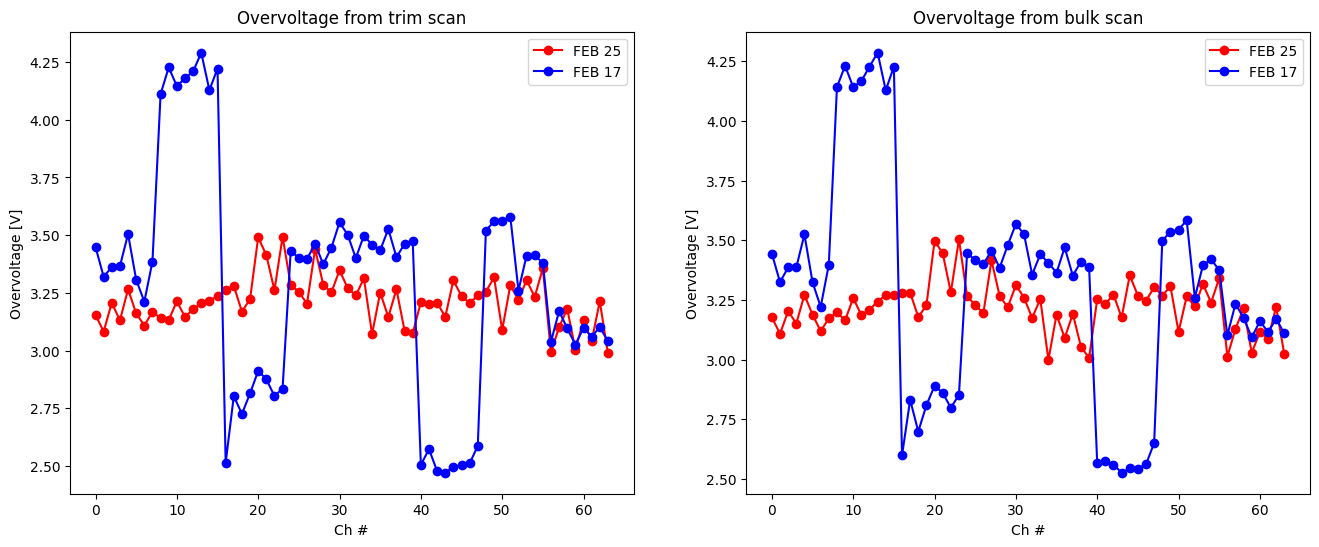

In [5]:
ch_list = [i for i in range(64)]
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].plot(ch_list, vover_trim[0], '-o', c='r', label='FEB 25')
axes[0].plot(ch_list, vover_trim[1], '-o', c='b', label='FEB 17')
axes[0].set_title('Overvoltage from trim scan')
axes[0].set_xlabel('Ch #')
axes[0].set_ylabel('Overvoltage [V]')
axes[0].legend()
axes[1].plot(ch_list, vover_bulk[0], '-o', c='r', label='FEB 25')
axes[1].plot(ch_list, vover_bulk[1], '-o', c='b', label='FEB 17')
axes[1].set_title('Overvoltage from bulk scan')
axes[1].set_xlabel('Ch #')
axes[1].set_ylabel('Overvoltage [V]')
axes[1].legend()
plt.show()

FROM TRIM 2.4711009772337276 4.290408893497442
[[3.1539721296379994, 3.0826823176087665, 3.207772151882164, 3.1309424960003622, 3.2657345883143982, 3.161355403821381, 3.108383980917919, 3.168261794777961, 3.1413307469464637, 3.1331171661135997, 3.2133070074612333, 3.1462700627476643, 3.1786890663666254, 3.205836587505471, 3.216439716957141, 3.235705610077635, 3.2611223637974436, 3.2805819220736456, 3.168801950917311, 3.22292099244197, 3.4908007071101026, 3.4136712987549838, 3.2614396351809662, 3.493565116642776, 3.2846374629058204, 3.2546479225503075, 3.202978421560292, 3.4405595036103045, 3.2850460533357135, 3.2519737060767158, 3.347918812611167, 3.2710643681397613, 3.238795314317934, 3.312709624709155, 3.071219365034213, 3.251338680228311, 3.1459006470721205, 3.2659768486470258, 3.0856707688089062, 3.075583190550676, 3.209357516021406, 3.2025048899894535, 3.208066569679731, 3.1455881715692393, 3.304340942365256, 3.235531126312565, 3.2058830254241695, 3.2397605208121445, 3.25542750598

Text(0, 0.5, 'counts')

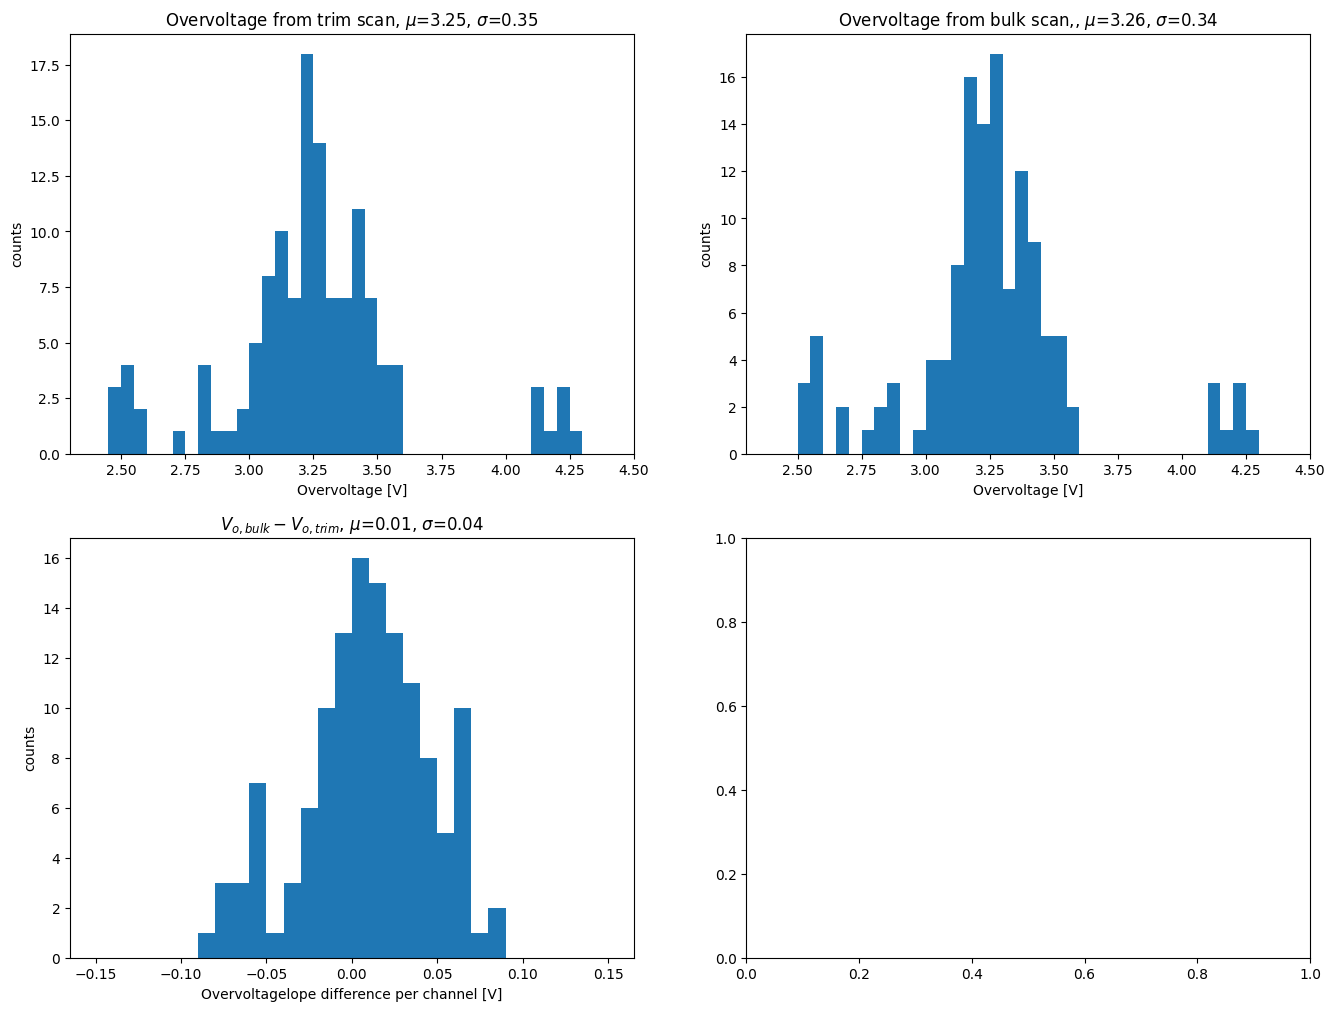

In [6]:
print("FROM TRIM", np.min(vover_trim), np.max(vover_trim))
print(vover_trim)
print("FROM BULK", np.min(vover_bulk), np.max(vover_bulk))
print(vover_bulk)
print("BULK-TRIM", np.min(vover_diff), np.max(vover_diff))
print(vover_diff)

vover_trim = np.array(vover_trim).flatten()
vover_bulk = np.array(vover_bulk).flatten()
vover_diff = np.array(vover_diff).flatten()

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes[0,0].hist(vover_trim, [2.4+0.05*i for i in range(40+1)])
axes[0,0].set_title("Overvoltage from trim scan, "+r'$\mu$'+"=%.2f"%(np.mean(vover_trim))+r', $\sigma$'+"=%.2f"%(np.std(vover_trim)))
axes[0,0].set_xlabel("Overvoltage [V]")
axes[0,0].set_ylabel("counts")
axes[0,1].hist(vover_bulk, [2.4+0.05*i for i in range(40+1)])
axes[0,1].set_title("Overvoltage from bulk scan,, "+r'$\mu$'+"=%.2f"%(np.mean(vover_bulk))+r', $\sigma$'+"=%.2f"%(np.std(vover_bulk)))
axes[0,1].set_xlabel("Overvoltage [V]")
axes[0,1].set_ylabel("counts")
axes[1,0].hist(vover_diff, [-.15+0.01*i for i in range(30+1)])
axes[1,0].set_title(r'$V_{o,bulk}-V_{o,trim}$, '+r'$\mu$'+"=%.2f"%(np.mean(vover_diff))+r', $\sigma$'+"=%.2f"%(np.std(vover_diff)))
axes[1,0].set_xlabel("Overvoltagelope difference per channel [V]")
axes[1,0].set_ylabel("counts")

1. The points with 0 y-coordinates are caused by bad fitting in calibration. The fitting range is not optimal for runs with lower bias voltages.
2. Effects of bulk bias and trim changes are relatively consistent. Difference between modifying by bulk and by trim is typically less than 1%. Across the channels, changing rates of SPE per ADC change in the settings (both trim and bias) are consistent within ~2.5%. Typical overvoltage calculated from the fittings are about 3V for $\Delta bias = 0$, which is consistent with our settings. It appears that breakdown calibration using SPE is possible, although this method is difficult to perform online.

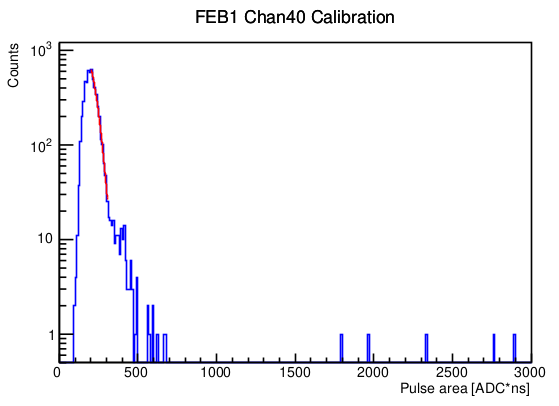